<a href="https://colab.research.google.com/github/adamzbikowski/Process-Mining-Dissertation/blob/main/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 1: predicting missing values for activity

##Section 0: Customisation

**Note on usage:**
To customise the pipeline, only alter the parameters in this section.

In [689]:
# The following parameters can be customised:

# change depending on which branch the queries have been pushed to
BRANCH = "sql-queries" 

# change this to change which query is being used
QUERY_NAME = "event_log_mvp_v2.sql"

# change to alter the number of random traces being selected
# set value to None in order to use the full dataset
NUM_TRACES = 100

# change to alter the prefix/suffix length
PREFIX_LENGTH = 5

# change to alter the size of the test and validation sets
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

# change to alter hyperparameters





## Section 1: Loading event log

In [610]:
# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [611]:
from google.colab import auth
auth.authenticate_user()

In [612]:
# this assumes that the user has access to the mimic-iii dataset 
# replace project name to the project containing mimic-iii
project_name = "processmining-367815" 
from google.cloud import bigquery
client = bigquery.Client(project=project_name)

In [613]:
import requests

# read a query from the github repository
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{BRANCH}/sql_queries/{QUERY_NAME}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

In [614]:
import pandas as pd

# loading event log from mimic-iii using bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


,patient,activity,timestamp
0,156279,Entered ICU,2133-10-23 15:19:16
1,118521,Entered ICU,2122-08-07 14:35:31
2,117800,Entered ICU,2143-08-21 00:20:52
3,196011,Entered ICU,2154-07-02 12:09:06
4,199270,Entered ICU,2136-08-01 16:35:56
...,...,...,...
175609,109352,Admitted,2167-04-01 16:57:00
175610,166032,Admitted,2198-09-08 20:03:00
175611,120514,Admitted,2163-09-07 13:31:00
175612,175280,Admitted,2204-01-20 16:12:00


## Section 2: Process Discovery

In [615]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-615-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.8/dist-packages/pm4py/utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[constants.CASE_CONCEPT_NAME].astype("string")
/usr/local/lib/python3.8/dist-packages/pm4py/utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

Number of cases: 42652
Number of events: 175612
Start events: {'Admitted': 41946, 'Entered ICU': 650, 'Discharged': 56}
End events: {'Discharged': 34700, 'Left ICU': 7947, 'Admitted': 5}


In [616]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model

event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])

In [617]:
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)

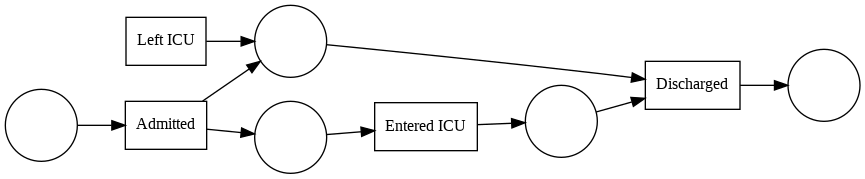

In [618]:
import graphviz
pm.view_petri_net(petri_net=net)

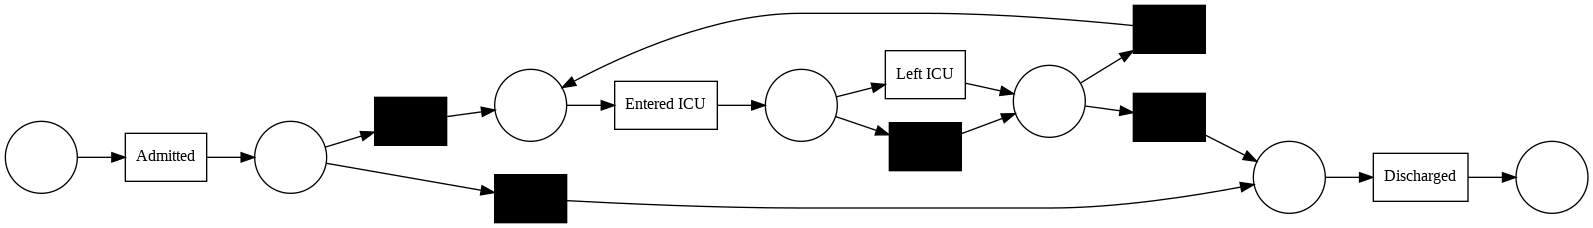

In [619]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

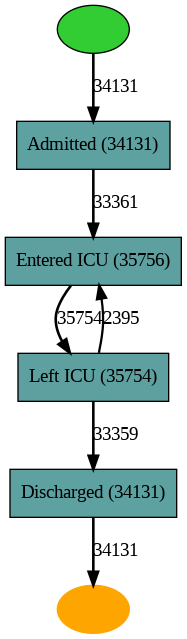

In [620]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

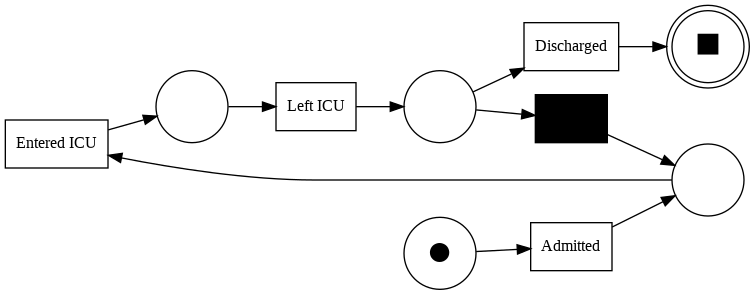

In [621]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

## Section 3: Data Pre Processing



In [690]:
from pandas.core.window.ewm import partial
import random

def partial_log(el, n):

  # select the first n cases to test the LSTM methodology
  # lets first add a trace column to the event_log
  el['trace'] = el.groupby(['patient']).ngroup()
  el = el[['trace', 'activity', 'timestamp' ]].reset_index(drop=True)
  # if n is None, return full event log
  if n is None:
    return el

  # initialise random seed and array of traces
  random.seed(9)
  random_traces = []

  for i in range(0,n):
    random_traces.append(random.randrange(0,n_cases))

  partial_el = event_log[event_log['trace'].isin(random_traces)]
  return partial_el


In [691]:
partial_el = partial_log(event_log, NUM_TRACES)
# partial_el

In [692]:
# lets represent each activity using a statically defined number
# this will prevent the need for using an embedding layer when traing the LSTM
unique_activities = partial_el['activity'].unique()
n_activities = len(unique_activities) + 1
encode_activity = {unique_activities[i-1] : f'{i}' for i in range(1,n_activities)}

# lets also create a second dictionary that will be used to decode predicted activities
decode_activity = {f'{i}' : unique_activities[i-1] for i in range(1, len(unique_activities)+ 1)}
encode_activity, decode_activity


({'Admitted': '1', 'Entered ICU': '2', 'Left ICU': '3', 'Discharged': '4'},
 {'1': 'Admitted', '2': 'Entered ICU', '3': 'Left ICU', '4': 'Discharged'})

In [712]:
import numpy as np
# create a new labeled data frame

def label(el):
  prefix_delta = []
  suffix_delta = []
  
  
  # initialise data frame 
  prefix_arr, suffix_arr, label_arr = [], [], []
  labeled_arr = []
  unique_traces = el['trace'].unique()
  traces = {x : pd.DataFrame() for x in unique_traces} 

  for t in unique_traces:
    traces[t] = el[:][el.trace == t]  
  
  for t in unique_traces:
    df = traces[t].sort_values(by='timestamp')
    activities = []
    timestamps = []
    for i in df.index:
      activity = encode_activity.get(df['activity'][i])
      activities.append(activity)
      timestamps.append(df['timestamp'][i])
    
    length = len(activities)
    
    for i in range(length):

      # prefix = activities[:i]
      label = activities[i]
      prefix = activities[:i]
      suffix = []

      prefix_times = timestamps[:i+1]
      suffix_times = []


      if i != length - 1:
        suffix = activities[i+1:]
        suffix_times = timestamps[i:]
      padding = []

      while len(prefix) + len(padding) < PREFIX_LENGTH:
        padding.append('0')
      
      prefix = padding + prefix
        
      while len(suffix) < PREFIX_LENGTH:
        suffix.append('0')

      prefix_arr.append(np.array(prefix[0:PREFIX_LENGTH], dtype=int))
      suffix_arr.append(np.array(suffix[0:PREFIX_LENGTH], dtype=int))
      label_arr.append(label)
      
      print(suffix_times)
      print('---')
      print(prefix_times)
      print('---')
    

  return pd.DataFrame({'prefix' : prefix_arr, 'suffix' : suffix_arr,
                      #  'prefix delta' : prefix_delta, 'suffix delta': suffix_delta,
                       'label' : label_arr})
 

In [713]:
from sklearn.model_selection import train_test_split

# label event log
labeled_el = label(partial_el)

# split event log into a train and test set  
train_el, test_el  = train_test_split(labeled_el, test_size=TEST_SIZE, random_state=9)
train_el


[Timestamp('2117-01-12 18:41:00'), Timestamp('2117-01-12 18:41:57'), Timestamp('2117-01-15 06:16:21'), Timestamp('2117-01-16 14:16:00')]
---
[Timestamp('2117-01-12 18:41:00')]
---
[Timestamp('2117-01-12 18:41:57'), Timestamp('2117-01-15 06:16:21'), Timestamp('2117-01-16 14:16:00')]
---
[Timestamp('2117-01-12 18:41:00'), Timestamp('2117-01-12 18:41:57')]
---
[Timestamp('2117-01-15 06:16:21'), Timestamp('2117-01-16 14:16:00')]
---
[Timestamp('2117-01-12 18:41:00'), Timestamp('2117-01-12 18:41:57'), Timestamp('2117-01-15 06:16:21')]
---
[]
---
[Timestamp('2117-01-12 18:41:00'), Timestamp('2117-01-12 18:41:57'), Timestamp('2117-01-15 06:16:21'), Timestamp('2117-01-16 14:16:00')]
---
[Timestamp('2135-03-04 15:04:00'), Timestamp('2135-03-04 15:05:27'), Timestamp('2135-03-08 17:27:32'), Timestamp('2135-03-15 16:49:00')]
---
[Timestamp('2135-03-04 15:04:00')]
---
[Timestamp('2135-03-04 15:05:27'), Timestamp('2135-03-08 17:27:32'), Timestamp('2135-03-15 16:49:00')]
---
[Timestamp('2135-03-04 15

,prefix,suffix,label
37,"[0, 0, 1, 2, 3]","[0, 0, 0, 0, 0]",4
38,"[0, 0, 0, 0, 0]","[2, 3, 4, 0, 0]",1
223,"[0, 0, 1, 2, 3]","[0, 0, 0, 0, 0]",4
254,"[0, 0, 0, 0, 0]","[2, 3, 4, 0, 0]",1
15,"[0, 0, 0, 0, 1]","[3, 4, 0, 0, 0]",2
...,...,...,...
65,"[0, 0, 1, 2, 3]","[0, 0, 0, 0, 0]",4
125,"[0, 0, 0, 0, 1]","[3, 4, 0, 0, 0]",2
251,"[0, 0, 0, 0, 1]","[3, 4, 0, 0, 0]",2
56,"[0, 0, 0, 1, 2]","[4, 0, 0, 0, 0]",3


In [695]:
from copy import deepcopy

# declare the label of each activity in the test set as missing
# return actual labels as targets array for validation
def missing(el):
 
  # need to deepcopy targets to derefrence them from dataframe  
  targets = deepcopy(el['label'])
  el['label'] = 'missing'
  return el, targets.to_numpy()

In [696]:
# train_targets = train_el['label'].to_numpy()
test_el, test_targets = missing(test_el)
test_el, test_targets

(              prefix           suffix    label
 155  [1, 2, 3, 2, 3]  [0, 0, 0, 0, 0]  missing
 101  [1, 2, 3, 2, 3]  [0, 0, 0, 0, 0]  missing
 286  [0, 0, 0, 0, 0]  [2, 3, 4, 0, 0]  missing
 232  [0, 0, 0, 0, 0]  [2, 3, 4, 0, 0]  missing
 53   [0, 0, 1, 2, 3]  [0, 0, 0, 0, 0]  missing
 ..               ...              ...      ...
 166  [0, 0, 0, 0, 0]  [2, 3, 4, 0, 0]  missing
 188  [0, 0, 0, 1, 2]  [2, 3, 2, 3, 4]  missing
 30   [0, 0, 0, 0, 0]  [2, 3, 4, 0, 0]  missing
 139  [0, 0, 0, 0, 1]  [3, 4, 0, 0, 0]  missing
 127  [0, 0, 1, 2, 3]  [0, 0, 0, 0, 0]  missing
 
 [68 rows x 3 columns],
 array(['4', '4', '1', '1', '4', '3', '2', '4', '1', '3', '1', '3', '1',
        '4', '1', '4', '4', '1', '2', '2', '2', '3', '4', '2', '2', '2',
        '3', '2', '4', '1', '3', '3', '2', '3', '1', '2', '2', '4', '1',
        '4', '2', '1', '1', '4', '1', '2', '3', '2', '4', '2', '3', '3',
        '4', '4', '1', '3', '2', '4', '3', '2', '3', '1', '3', '1', '3',
        '1', '2', '4'], dtype=obj

In [697]:
# create validation set
train_el, validation_el = train_test_split(train_el, test_size=VALIDATION_SIZE, random_state=9)

In [698]:
from keras.utils import to_categorical

def format_input(el, train=False):

  prefix_x = np.array(el['prefix'])
  prefix_x = np.stack(prefix_x)
  prefix_x = prefix_x.reshape(prefix_x.shape[0], prefix_x.shape[1], 1)
  
  suffix_x = np.array(el['suffix'])
  suffix_x = np.stack(suffix_x)
  suffix_x = suffix_x.reshape(suffix_x.shape[0], suffix_x.shape[1], 1)

  x = np.concatenate(([prefix_x], [suffix_x]))

  y = np.array(el['label'])
  y = np.stack(y)
  
  if train is False:
    y_encoded = to_categorical(y,n_activities)
    return x, y_encoded
  
  return x, y

In [699]:
train_x, train_y = format_input(train_el) 
validation_x, validation_y = format_input(validation_el)
test_x, test_y = format_input(test_el, train=True)


## Section 4: Predicting Missing Activities using LSTM

###4.1 Prefix LSTM

In [485]:
# forwards LSTM
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, Dense, Softmax, Bidirectional, Embedding


prefix_LSTM = Sequential()
prefix_LSTM.add(Embedding(input_dim=n_activities, output_dim=50))
prefix_LSTM.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(PREFIX_LENGTH, 1)))
prefix_LSTM.add(Dense(n_activities, activation='softmax'))

prefix_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
prefix_LSTM.summary()
prefix_LSTM.fit(train_x[0], train_y, validation_data=(validation_x[0], validation_y), epochs=10)


Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, None, 50)          300       
                                                                 
 lstm_50 (LSTM)              (None, 50)                20200     
                                                                 
 dense_40 (Dense)            (None, 6)                 306       
                                                                 
Total params: 20,806
Trainable params: 20,806
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
8/8 [==============================] - 3s 62ms/step - loss: 1.7791 - accuracy: 0.4206 - val_loss: 1.7671 - val_accuracy: 0.3750
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 1.7563 - accuracy: 0.4405 - val_loss: 1.7404 - val_accuracy: 0.4062
Epoch 3/10
8/8 [===================

###4.2 Suffix LSTM

In [486]:
# backwards LSTM

suffix_LSTM = Sequential()
suffix_LSTM.add(Embedding(input_dim=n_activities, output_dim=50))
suffix_LSTM.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(PREFIX_LENGTH, 1)))
suffix_LSTM.add(Dense(n_activities, activation='softmax'))

suffix_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
suffix_LSTM.summary()
suffix_LSTM.fit(train_x[1], train_y, validation_data=(validation_x[1], validation_y), epochs=10)


Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_52 (Embedding)    (None, None, 50)          300       
                                                                 
 lstm_51 (LSTM)              (None, 50)                20200     
                                                                 
 dense_41 (Dense)            (None, 6)                 306       
                                                                 
Total params: 20,806
Trainable params: 20,806
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
8/8 [==============================] - 3s 123ms/step - loss: 1.7857 - accuracy: 0.2024 - val_loss: 1.7776 - val_accuracy: 0.1875
Epoch 2/10
8/8 [==============================] - 0s 23ms/step - loss: 1.7705 - accuracy: 0.2421 - val_loss: 1.7636 - val_accuracy: 0.2031
Epoch 3/10
8/8 [==================

###4.3 Bidirectional LSTM

In [685]:
from pandas.core.internals import concat
# Bidirectional LSTM
from keras.layers import Bidirectional, Input, concatenate, average
from keras import Model

prefix_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_input')
suffix_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_input')

lstm_layer = LSTM(50)

prefix_layer = Bidirectional(lstm_layer, name='prefix_lstm')(prefix_input)
suffix_layer = Bidirectional(lstm_layer, name='suffix_lstm')(suffix_input)

merged = concatenate([prefix_layer, suffix_layer], name='merged')

output = Dense(n_activities, activation='softmax', name='output')(merged)

bi_LSTM = Model(inputs=[prefix_input, suffix_input], outputs=output)
bi_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_LSTM.summary()
bi_LSTM.fit((train_x[0], train_x[1]), train_y,  validation_data=((validation_x[0], validation_x[1]), validation_y), epochs=10)

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 suffix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 prefix_lstm (Bidirectional)    (None, 100)          20800       ['prefix_input[0][0]']           
                                                                                                  
 suffix_lstm (Bidirectional)    (None, 100)          20800       ['suffix_input[0][0]']           
                                                                                           

###4.4 Bidirectional LSTM with TimeDelta

In [688]:
prefix_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_input')
suffix_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_input')

prefix_time_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_time_input')
suffix_time_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_time_input')

prefix_merged = concatenate([prefix_input, prefix_time_input], axis=-1)
suffix_merged = concatenate([suffix_input, suffix_time_input], axis=-1)

lstm_layer = LSTM(50)

prefix_layer = Bidirectional(lstm_layer, name='prefix_lstm')(prefix_merged)
suffix_layer = Bidirectional(lstm_layer, name='suffix_lstm')(suffix_merged)

merged = concatenate([prefix_layer, suffix_layer], name='merged')

output = Dense(n_activities, activation='softmax', name='output')(merged)

bi_LSTM = Model(inputs=[prefix_input, suffix_input, prefix_time_input, suffix_time_input], outputs=output)
bi_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_LSTM.summary()
# bi_LSTM.fit((train_x[0], train_x[1]), train_y,  validation_data=((validation_x[0], validation_x[1]), validation_y), epochs=10)

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 prefix_time_input (InputLayer)  [(None, 5, 1)]      0           []                               
                                                                                                  
 suffix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 suffix_time_input (InputLayer)  [(None, 5, 1)]      0           []                               
                                                                                           

##Section 5: Evaluation and Conformance Checking

###5.1 Statistical Evaluation

In [ ]:
def evaluate(predictions, verbose=False):
  correct = 0 
  incorrect = 0
  for i in range(len(test_targets)):
    prediction = np.argmax(predictions[i])
    if int(prediction) == int(test_targets[i]):
      correct += 1
    else:
      if verbose:
        print(f"predicted : {prediction}; expected : {test_targets[i]}")
      incorrect += 1


  accuracy = correct/(correct + incorrect)
  return accuracy

In [ ]:
# prefix-LSTM
predictions_prefix = prefix_LSTM.predict(test_x[0])
evaluate(predictions_prefix)

23/23 [==============================] - 0s 2ms/step


0.9100817438692098

In [ ]:
# suffix-LSTM
predictions_suffix = suffix_LSTM.predict(test_x[1])
evaluate(predictions_suffix)

23/23 [==============================] - 0s 2ms/step


0.9182561307901907

In [ ]:
# averaging outputs
predictions = []
for p in zip(predictions_prefix, predictions_suffix):
 
  arr = []
  for i in range(0,4):
    arr.append((p[0][i]+p[1][i])/2)
  predictions += [arr]

predictions = np.array(predictions)

evaluate(predictions)

0.5871934604904632

In [686]:
# bi-LSTM
predictions_bi = bi_LSTM.predict([test_x[0], test_x[1]])
evaluate(predictions_bi)

874/874 [==============================] - 9s 5ms/step


0.9999642282239313

###5.2 Conformance Checking